In [6]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt

# CIFAR10


In [7]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.CIFAR10(root='./data', train=True,  download=True,transform=trans)
test_set = dset.CIFAR10(root='./data', train=False, transform=trans)

Files already downloaded and verified


In [8]:
BATCH_SIZE=64
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
batch=next(iter(train_loader))
print(batch[0].size())
print(train_loader.dataset.data.shape)
print(test_loader.dataset.data.shape)



torch.Size([64, 3, 32, 32])
(50000, 32, 32, 3)
(10000, 32, 32, 3)


# VGG16

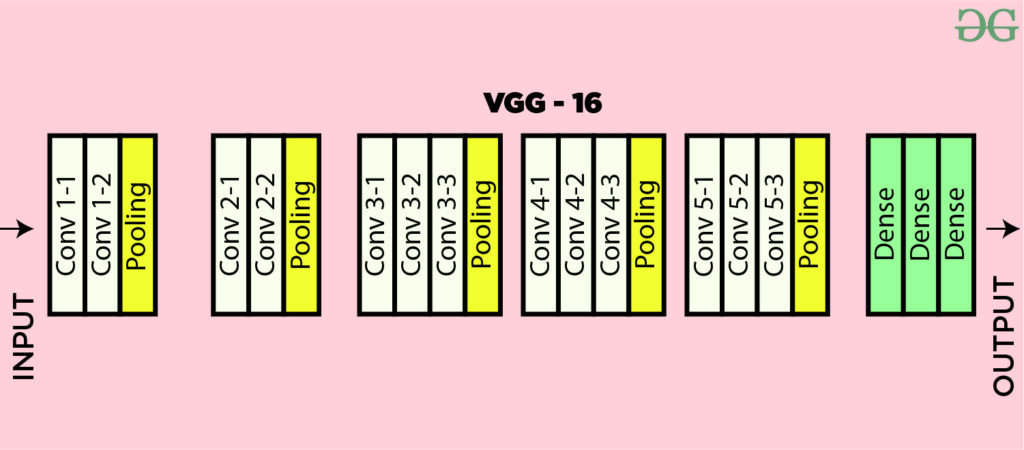

In [17]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 1024),
            nn.Linear(1024, 2048),
            nn.Linear(2048, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [12]:
def test(model, test_loader, criterion):
    model.eval()
    test_losses = []
    test_accuracies = []
    

    for _, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / len(labels)
        test_accuracies.append(accuracy)

    return test_losses, test_accuracies

In [13]:
EPOCHS=2

def train(model, train_loader, optimizer, criterion):
    train_losses = []
    test_losses = []
    test_accuracies = []

    model.train()

    for epoch in range(EPOCHS):
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images)
            labels = Variable(labels)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            if i%100==0:
            
                tl, ta = test(model, test_loader, criterion)
                test_losses.extend(tl)
                test_accuracies.extend(ta)

                print(f'Epoch {epoch+1}/{EPOCHS}, Step {i+1}/{len(train_loader)}\n - Train Loss: {loss.item()}')
                print(f' - Test Loss: {tl[-1]}\n - Test Accuracy: {ta[-1]}')

            if sum(test_accuracies[-3:])/3 > 0.95:
                print('Performance condition satisfied.')
                return train_losses, test_losses, test_accuracies
            

    return train_losses, test_losses, test_accuracies



In [18]:
model = VGG16()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses, test_losses, test_accuracies = train(model, train_loader, optimizer, criterion)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title("Train Loss")

plt.subplot(1, 3, 2)
plt.plot(test_losses)
plt.title("Test Loss")

plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.show()


print(f"Average Test Loss: {sum(test_losses)/len(test_losses)}")
print(f"Average Test Accuracy: {sum(test_accuracies)/len(test_accuracies)}")

Epoch 1/2, Step 1/782
 - Train Loss: 2.3010764122009277
 - Test Loss: 2.384089231491089
 - Test Accuracy: 0.1875
Epoch 1/2, Step 101/782
 - Train Loss: 671.4678955078125
 - Test Loss: 328.20257568359375
 - Test Accuracy: 0.3125
Epoch 1/2, Step 201/782
 - Train Loss: 5.516602039337158
 - Test Loss: 6.760612487792969
 - Test Accuracy: 0.1875
Epoch 1/2, Step 301/782
 - Train Loss: 3.3052847385406494
 - Test Loss: 2.8647828102111816
 - Test Accuracy: 0.3125
Epoch 1/2, Step 401/782
 - Train Loss: 2.630009174346924
 - Test Loss: 2.2701656818389893
 - Test Accuracy: 0.3125
Epoch 1/2, Step 501/782
 - Train Loss: 2.5020008087158203
 - Test Loss: 2.2706611156463623
 - Test Accuracy: 0.3125
Epoch 1/2, Step 601/782
 - Train Loss: 1.9621096849441528
 - Test Loss: 1.9112415313720703
 - Test Accuracy: 0.25
Epoch 1/2, Step 701/782
 - Train Loss: 1.8395917415618896
 - Test Loss: 1.7135143280029297
 - Test Accuracy: 0.375
Epoch 2/2, Step 1/782
 - Train Loss: 1.9425898790359497
 - Test Loss: 1.7996332645

KeyboardInterrupt: 